In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
def mult_normality(data, cols, method='shapiro', hist=True, qq=True, prt=False):
    table = None
    res = []
    for col in cols:
        X = data[col]
        tst = test()
        if hist:
            hist_name = 'Distribution of '+col
        
        tst.sgl_normality(X=X, method=method, hist=hist, qq=qq, prt=prt)
        res.append(tst.res)
        
        if method == 'anderson':
            tmp_table = tst.table
            tmp_table.index = [col +"_"+ c for c in tmp_table.index]
            table = pd.concat([table,tmp_table],axis=0)
        elif method == 'shapiro':
            tmp_table = tst.table
            tmp_table.index = [col]
            table = pd.concat([table,tmp_table],axis=0)
        elif method == 'kolmogorov':
            tmp_table = tst.table
            tmp_table.index = [col]
            table = pd.concat([table,tmp_table],axis=0)
    
    tst = test()  
    tst.res = res
    tst.table = table
    
    return tst
            
        
class test:
    def __init__(self):
        self.res = None
        self.type = None
        self.table = None 
    
    # test normality of one single sample
    def sgl_normality(self, X, method='shapiro', hist_name=None, hist=True, qq=True, prt=True):
        self.type = 'normality test'

        # plot the distribution if hist==True
        if hist:
            plt.figure(figsize=(8, 6), dpi=100)
            if hist_name is not None:
                plt.title(hist_name)
            sns.distplot(X, rug=False, hist=True, kde=True, label = 'Sample distribution')
            support = np.linspace(min(X), max(X), num=100)
            dens = norm.pdf(support, loc=np.mean(X), scale=np.std(X))
            sns.lineplot(support, dens, label='Gaussian with sample mean and std')
        
        # plot the qq-plot
        if qq:
            plt.figure(figsize=(8, 6), dpi=100)
            stats.probplot(X, plot=sns.mpl.pyplot)
        
        # normality test
        if method == 'anderson': 
            # anderson test 
            # return decisions for different significance levels
            self.res = stats.anderson(X, dist='norm')
            self.table = pd.DataFrame(np.concatenate(([self.res.significance_level],
                                                 [self.res.critical_values],[self.res.critical_values]),axis=0))
            self.table.index = ['sig_level','crit_vals','decision']
            #print("ad_stat:", res.statistic)
            self.table.loc['decision'] = (self.table.loc['crit_vals']<self.res.statistic)
            self.table.loc['decision'] = self.table.loc['decision'].apply(lambda x: 'Rej' if x else 'no Rej')
        
        if method == 'shapiro':
            # shapiro test
            self.res = stats.shapiro(X)
            self.table = pd.DataFrame([['{:.4e}'.format(float(self.res[0])),'{:.4e}'.format(float(self.res[1]))]])
            self.table.columns = ['test stat','p-value']
            if prt:
                print("Shapiro test statistic:",'{:.4e}'.format(float(self.res[0])) )
                print("Shapiro test p-value:",'{:.4e}'.format(float(self.res[1])) )
            
        if method == 'kolmogorov':
            # Kolmogorov-Smirnov test
            self.res = stats.kstest(X, 'norm')
            self.table = pd.DataFrame([['{:.4e}'.format(float(self.res[0])),'{:.4e}'.format(float(self.res[1])) ]])
            self.table.columns = ['test stat','p-value']
            if prt:
                print("Kolmogorov-Smirnov test statistic:",'{:.4e}'.format(float(self.res[0])) )
                print("Kolmogorov-Smirnov test p-value:",'{:.4e}'.format(float(self.res[1])) )
                       
    # 1-sample t tests whether mean is mu, requires normality
    # but if sample size > 15, robust
    # or use Wilcoxon Test by setting normality=False
    # data is a dataframe, cols indicating which columns to test
    # mu is the target mean array
    def t_1sample(self, data, cols, mu, normality=True):
        self.type = 'one-sample t test'
        
        if normality:
            # usual t-test
            self.res = stats.ttest_1samp(data[cols], mu)
            self.table = pd.concat((pd.DataFrame(['{:.4e}'.format(float(c)) for c in self.res[0]]),
                                    pd.DataFrame(['{:.4e}'.format(float(c)) for c in self.res[1]])),axis=1)
            self.table.columns = ['test stat','p-value']
            self.table.index = cols
        else:
            # wilcoxon t-test
            self.res = []
            for i in range(len(mu)):
                x = data[cols[i]]
                tmp_res = stats.wilcoxon(x - mu[i])
                self.res.append(tmp_res)
                tmp_table = pd.DataFrame(['{:.4e}'.format(tmp_res[0]),'{:.4e}'.format(tmp_res[1])]).transpose()
                self.table = pd.concat((self.table,tmp_table),axis=0)
            self.table.columns = ['test stat','p-value']
            self.table.index = cols
            
    # test whether group 1 and 2 has different mean
    # perform welch-t if normality == False
    # plot violin plot of two samples if plot == True
    # print results if prt == True
    def t_2sample(self, gp1, gp2, normality=True, plot=True, prt=True, sig_level=0.05):
        self.type = '2-sample t test'
        self.res = stats.ttest_ind(gp1, gp2, equal_var=normality, nan_policy='omit')
        table = pd.DataFrame(['{:.4e}'.format(float(c)) for c in self.res]).transpose()
        table.columns = ['test stat', 'p-value']
        self.table = table
        reject = False
        if self.res[1] < sig_level:
            reject = True
        
        if prt:
            print("2-sample test statistic: ",'{:.4e}'.format(float(self.res[0])))
            print("2-sample test p-value: ",'{:.4e}'.format(float(self.res[1])))
            if reject:
                print("have confidence to assert the groups have different means at significant level",sig_level)
            else:
                print("have no evidence to say the groups have different means at significant level",sig_level)
        
        if plot:
            gp = pd.DataFrame({'group1':list(X.iloc[0:100]),
                   'group2':list(X.iloc[100:200])})
            gpp = gp.melt().assign(x='vars')
            plt.figure(figsize=(8, 6), dpi=100)
            plt.title('violin plot of two groups')
            sns.violinplot(data=gpp, x='x', y='value', 
                           hue='variable', split=True, inner='quart')
    
    # test H0: submodel (with p features in cols1) 
    #   vs H1: full model (q>p features in col2) in linear regression
    # calculate the residuals of the two Rsub, Rful (Rsub >= Rful)
    # under H0, (Rsub-Rful)/Rful * n-q/q-p ~ F_q-p,n-q
    def full_model_test(self, data, y, cols1, cols2, add_const=True, summary = False, prt = True, sig_lev = 0.05):
        if add_const:
            subX_ = sm.add_constant(data[cols1])
            fulX_ = sm.add_constant(data[cols2])
        n = len(y)
        p = len(cols1) + 1
        q = len(cols2) + 1
        submd = sm.OLS(y.values, np.asarray(subX_))
        fulmd = sm.OLS(y.values, np.asarray(fulX_))
        subres = submd.fit()
        fulres = fulmd.fit()
        self.res = [subres, fulres]
        
        if summary:
            print("summary of submodel:")
            print(subres.summary()) # Robusted Results
            print("summary of fullmodel:")
            print(fulres.summary())
        
        sub_resid = np.sum(subres.resid**2)
        ful_resid = np.sum(fulres.resid**2)
        F_stat = ((sub_resid-ful_resid)/(q-p)) / (ful_resid/(n-q))
        p_val = 1 - stats.f.cdf(F_stat, q-p, n-q)
        
        table = pd.DataFrame({"F_stat":['{:.4e}'.format(float(F_stat))], "p_value":['{:.4e}'.format(float(p_val))]})
        self.table = table
        
        if prt:
            print("F-test statistic is", '{:.4e}'.format(float(F_stat)))
            print("F-test has df",q-p,",",n-q)
            print("p-value is", '{:.4e}'.format(float(p_val)))
            if p_val > sig_lev:
                print("under significance level",sig_lev,"cannot say submodel is not sufficient")
            else: #reject H0
                print("under significance level",sig_lev,"can say submodel is not sufficient")

In [4]:
def mult_normality(data, cols, method='shapiro', hist=True, qq=True, prt=False):
    table = None
    res = []
    for col in cols:
        X = data[col]
        tst = test()
        if hist:
            hist_name = 'Distribution of '+col
        
        tst.sgl_normality(X=X, method=method, hist=hist, qq=qq, prt=prt)
        res.append(tst.res)
        
        if method == 'anderson':
            tmp_table = tst.table
            tmp_table.index = [col +"_"+ c for c in tmp_table.index]
            table = pd.concat([table,tmp_table],axis=0)
        elif method == 'shapiro':
            tmp_table = tst.table
            tmp_table.index = [col]
            table = pd.concat([table,tmp_table],axis=0)
        elif method == 'kolmogorov':
            tmp_table = tst.table
            tmp_table.index = [col]
            table = pd.concat([table,tmp_table],axis=0)
    
    tst = test()  
    tst.res = res
    tst.table = table
    
    return tst
            

# Test normality

In [5]:
airbnb = pd.read_csv('data/airbnb.csv')
test_cols = ['log_price','latitude']

## test normality of given columns in a dataset

/Users/Momooo/anaconda2/envs/python36/lib/python3.6/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  """


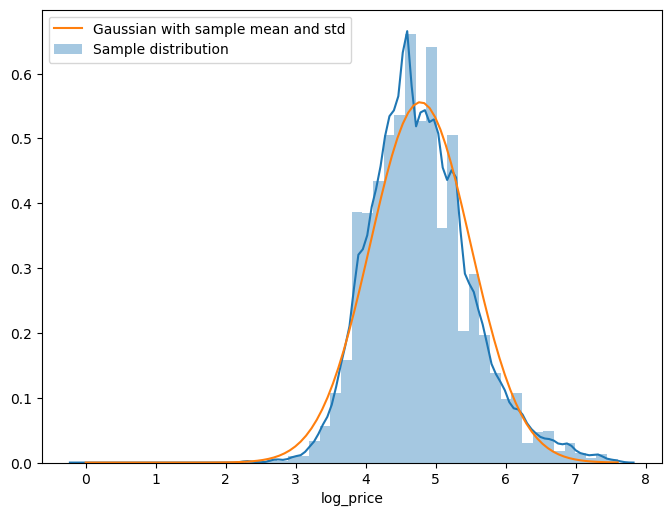

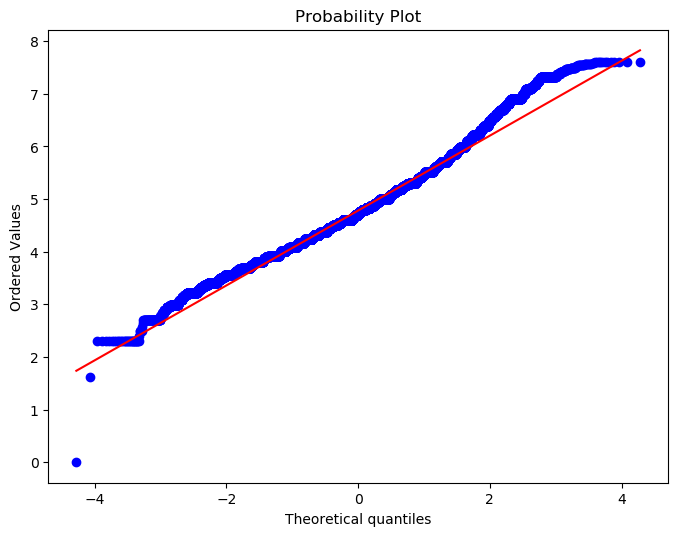

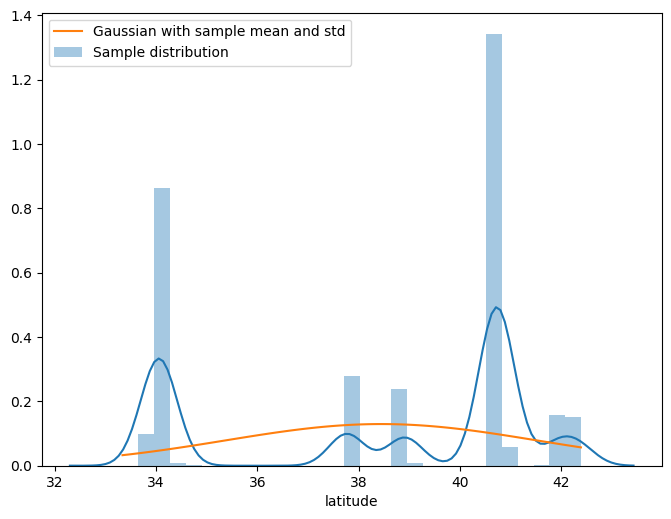

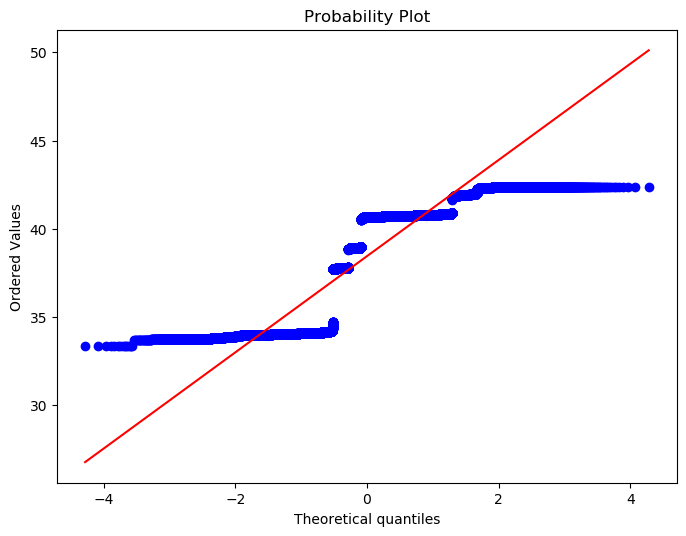

In [6]:
mytest = mult_normality(airbnb,cols=['log_price','latitude'],method='shapiro',hist=True,qq=True,prt=False)
# other options of test: method ='anderson','kolmogorov'

## show test statistics and p-values for all selected features

In [7]:
mytest.table

,test stat,p-value
log_price,9.8368e-01,0.0000e+00
latitude,7.8372e-01,0.0000e+00


# one sample t-test H_0: mean of sample = mu

In [8]:
# perform one-sample t-test on every column in cols
cls= ['log_price','latitude']

### plain t-test with normality

In [9]:
tst = test()
# mu is the corresponding target mean value
mean = np.array([0,0])
# normality = True for plain t-test
tst.t_1sample(data = airbnb, cols = cls, mu=mean, normality = True)
tst.table

,test stat,p-value
log_price,1.8147e+03,0.0000e+00
latitude,3.3980e+03,0.0000e+00


### Wilcoxon t-test for non-normality

In [10]:
tst = test()
# normality = False for wilcoxon t-test, deal with non-normality
tst.t_1sample(data = airbnb, cols=cls, mu=mean, normality = False)
tst.table

,test stat,p-value
log_price,0.0000e+00,0.0000e+00
latitude,0.0000e+00,0.0000e+00


# 2-sample t-test, H0: two sample means are equal

2-sample test statistic:  7.3721e-02
2-sample test p-value:  9.4131e-01
have no evidence to say the groups have different means at significant level 0.05


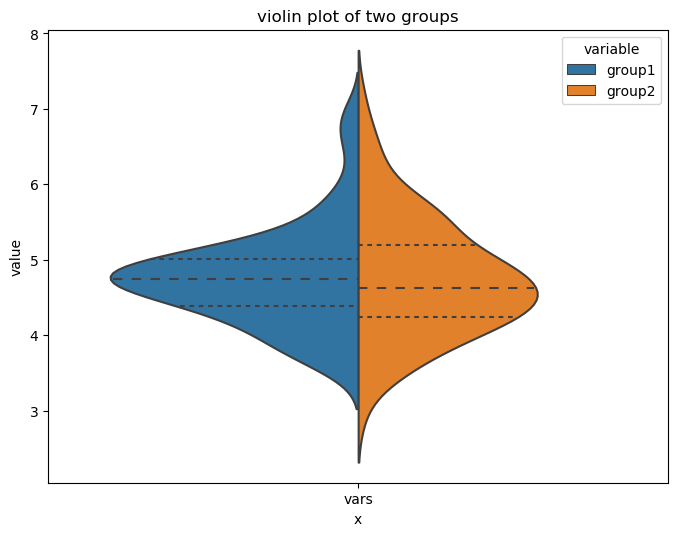

In [11]:
X = airbnb['log_price']
tst = test()
# use welch's t if normality == False
tst.t_2sample(X.iloc[0:100], X.iloc[100:200], normality=True, plot=True, prt=True, sig_level = 0.05)

# Violation of assmptions t-tests:

## One sample t-test

By CLT and Law of large numbers, the t statistic still converges to $N(0,1)$, which is the limit of $t_n$. So even $Y_i$ are not normal, the one-sample t-test is still valid.

## Two sample t-test

An assumption of 2-sample t-test is that the two samples have equal variance (homogeneity). The denominator has asymptotic varaince $\frac{\tau+\rho}{\tau\rho +1}$, with $n_1=\rho n_0$, $\sigma_1^2 = \tau \sigma_0^2$.

If sample sizes are equal ($n_0=n_1$), we don't worry about whether variances are equal.

If sample sizes are not equal, use welch's t.

# F test for H0: submodel vs H1: fullmodel

In [12]:
crime = pd.read_csv('data/crime.csv', encoding='unicode_escape', parse_dates=['OCCURRED_ON_DATE'])

In [13]:
reg_data = crime.groupby('REPORTING_AREA').mean()
reg_data.head(10)
reg_data['NUM'] = crime.REPORTING_AREA.value_counts()

In [14]:
# features for submodel
sub_col = ['HOUR', 'Lat', 'Long']
# feature for fullmodel
full_col = ['MONTH', 'HOUR', 'Lat', 'Long']

In [15]:
tst = test()
tst.full_model_test(reg_data, reg_data['NUM'], sub_col, full_col, add_const=True, 
                    summary = True, prt = True, sig_lev = 0.05)

summary of submodel:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     17.03
Date:                Fri, 24 Jan 2020   Prob (F-statistic):           9.38e-11
Time:                        00:14:27   Log-Likelihood:                -7033.4
No. Observations:                 879   AIC:                         1.407e+04
Df Residuals:                     875   BIC:                         1.409e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6553.4729   1101.90

/Users/Momooo/anaconda2/envs/python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [16]:
tst.table

,F_stat,p_value
0,4.6210e-04,9.8285e-01


# F test: k-group means

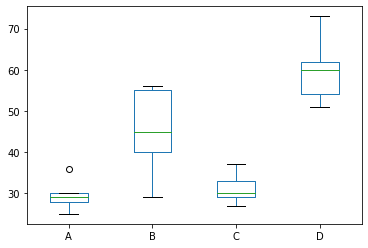

In [17]:
d = pd.read_csv("https://reneshbedre.github.io/myfiles/anova/onewayanova.txt", sep="\t")
# generate a boxplot to see the data distribution by treatments. Using boxplot, we can easily detect the differences 
# between different treatments
d.boxplot(column=['A', 'B', 'C', 'D'], grid=False)

### conduct f-test of group means and return results

In [18]:
fvalue, pvalue = stats.f_oneway(d['A'], d['B'], d['C'], d['D'])
print(fvalue, pvalue)

17.492810457516338 2.639241146210922e-05


In [19]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols
# reshape the d dataframe suitable for statsmodels package 
d_melt = pd.melt(d.reset_index(), id_vars=['index'], value_vars=['A', 'B', 'C', 'D'])
# replace column names
d_melt.columns = ['index', 'treatments', 'value']
# Ordinary Least Squares (OLS) model
model = ols('value ~ C(treatments)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(treatments),3010.95,3.0,17.49281,0.000026
Residual,918.00,16.0,NaN,NaN


### To know which two pairs are different: pairwise test

From ANOVA analysis, we know that treatment differences are statistically significant, but ANOVA does not tell which treatments are significantly different from each other. To know the pairs of significant different treatments, we will perform multiple pairwise comparison (Post-hoc comparison) analysis using Tukey HSD test.

In [20]:
# load packages
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=d_melt['value'], groups=d_melt['treatments'], alpha=0.05)
print(m_comp)


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B     15.4 0.0251   1.6929 29.1071   True
     A      C      1.6    0.9 -12.1071 15.3071  False
     A      D     30.4  0.001  16.6929 44.1071   True
     B      C    -13.8 0.0482 -27.5071 -0.0929   True
     B      D     15.0 0.0296   1.2929 28.7071   True
     C      D     28.8  0.001  15.0929 42.5071   True
-----------------------------------------------------


# Violation of assumptions of k-group F-test

## Assumptions:

Normality, equal variances, independence.

## Violation of normality

The one-way ANOVA is considered a robust test against the normality assumption, as long as the sample size is not too small. 

As regards the normality of group data, the one-way ANOVA can tolerate data that is non-normal (skewed or kurtotic distributions) with only a small effect on the Type I error rate.

## Violation of equal variance

A saying: there's a rule of thumb that the ANOVA is robust to heterogeneity of variance so long as the largest variance is not more than 4 times the smallest variance. Furthermore, the general effect of heterogeneity of variance is to make the ANOVA less efficient. That is, you would have lower power.

Another saying: According to Blanca (2017), the rule of thumb is that the variance ratio (VR) above 1.5 can be considered a threat to the robustness of the F-test w/ unequal sample size. Thus, usage of ANOVA should be taken with serious caution. There are many potential alternatives to the ANOVA w/ unbalanced sample size eg: Kursal-Wallis test, Welch ANOVA..

### Alternative: Kursal-Wallis test

! still unstable (according to the webpage in next welch Anova)

The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes. Note that rejecting the null hypothesis does not indicate which of the groups differs. Post hoc comparisons between groups are required to determine which groups are different.

In [69]:
# Null hypothesis: Null hypothesis assumes that the samples (groups) are from identical populations.
# Alternative hypothesis: Alternative hypothesis assumes that at least one of the samples (groups) 
# comes from a different population than the others.
from scipy import stats
x = [1, 1, 1]
y = [2, 2, 2]
z = [2, 2]
stats.kruskal(x, y, z)


KruskalResult(statistic=7.0, pvalue=0.0301973834223185)

### Maybe better alternative: Welch Anova

suitable for normality but unequal variance

https://www.statisticshowto.datasciencecentral.com/welchs-anova/

In [67]:
from pingouin import welch_anova, read_dataset
df = read_dataset('anova')
aov = welch_anova(dv='Pain threshold', between='Hair color', data=df)
aov

,Source,ddof1,ddof2,F,p-unc
0,Hair color,3,8.33,5.89,0.018813


# Two-way ANOVA F-test

Suppose there are two factors: A with $I$ and B with $J$ levels. Samples are $Y_{ijk}$ $k=1,\dots,n_{ij}$ corresponding to category $(i,j)$, and $Y_{ijk}\sim N(\mu_{ij},\sigma^2)$ equal variance, we use two-way ANOVA to test the effects of $A$, $B$.

There are three kinds of hypotheses:

1. Factor A x Factor B interactions

2. Main effect of factor A

3. Main effect of factor B

In [21]:
moore = sm.datasets.get_rdataset("Moore", "carData",cache=True) 
data = moore.data
data = data.rename(columns={"partner.status":"partner_status"}) 

If Region had been an integer variable that we wanted to treat explicitly as categorical, we could have done so by using the C() operator:

In [22]:
moore_lm = ols('conformity ~ C(fcategory, Sum)*C(partner_status, Sum)', data=data).fit()
#moore_lm.summary()
table = sm.stats.anova_lm(moore_lm, typ=2)

Same results obtained from the following

In [23]:
moore_lm2 = ols('conformity ~ C(fcategory)*C(partner_status)', data=data).fit()
table = sm.stats.anova_lm(moore_lm2, typ=2)
table

,sum_sq,df,F,PR(>F)
C(fcategory),11.614700,2.0,0.276958,0.759564
C(partner_status),212.213778,1.0,10.120692,0.002874
C(fcategory):C(partner_status),175.488928,2.0,4.184623,0.022572
Residual,817.763961,39.0,NaN,NaN


# Tests for categorical data

## Pearson's chi-squared test of independence

In [24]:
table = np.array([[12,23,43],[212,423,356]])
stat, p, dof, expected = stats.chi2_contingency(table)
table

array([[ 12,  23,  43],
       [212, 423, 356]])

In [25]:
sig_lev = 0.05
if p < sig_lev:
    print("Reject independence at significance level", sig_lev)
else:
    print("Cannot reject independence at significance level",sig_lev)

Reject independence at significance level 0.05


## Fisher's Exact test (must be 2*2 table)

In [26]:
oddsratio, pvalue = stats.fisher_exact(table[0:2,0:2])
sig_lev = 0.05
if pvalue < sig_lev:
    print("Reject independence at significance level", sig_lev)
else:
    print("Cannot reject independence at significance level",sig_lev)

Cannot reject independence at significance level 0.05


# Changepoint detection

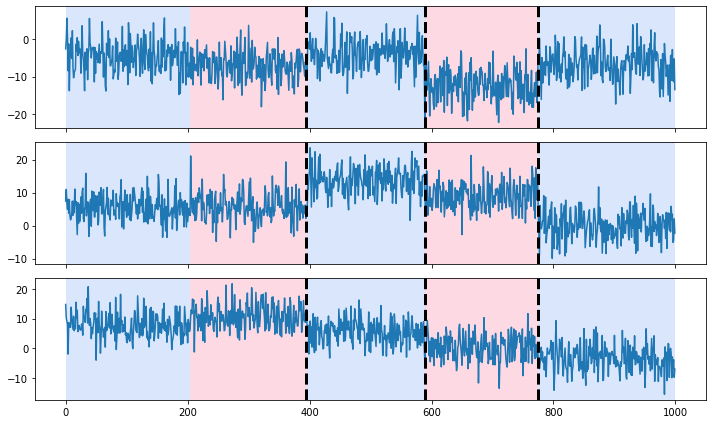

In [27]:
import matplotlib.pyplot as plt
import ruptures as rpt

# generate signal
n_samples, dim, sigma = 1000, 3, 4
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# detection
algo = rpt.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=10)

# display
rpt.display(signal, bkps, result)
plt.show()

# Bayesian Changepoint Detection in Python

This code computes the probability of changepoints in a time series.7 In this notebook I show how you can use it.

First let's generate some data:

In [28]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import seaborn


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [8]:
def generate_normal_time_series(num, minl=50, maxl=1000):
    data = np.array([], dtype=np.float64)
    partition = np.random.randint(minl, maxl, num)
    for p in partition:
        mean = np.random.randn()*10
        var = np.random.randn()*1
        if var < 0:
            var = var * -1
        tdata = np.random.normal(mean, var, p)
        data = np.concatenate((data, tdata))
    return data

In [9]:
data = generate_normal_time_series(7, 50, 200)

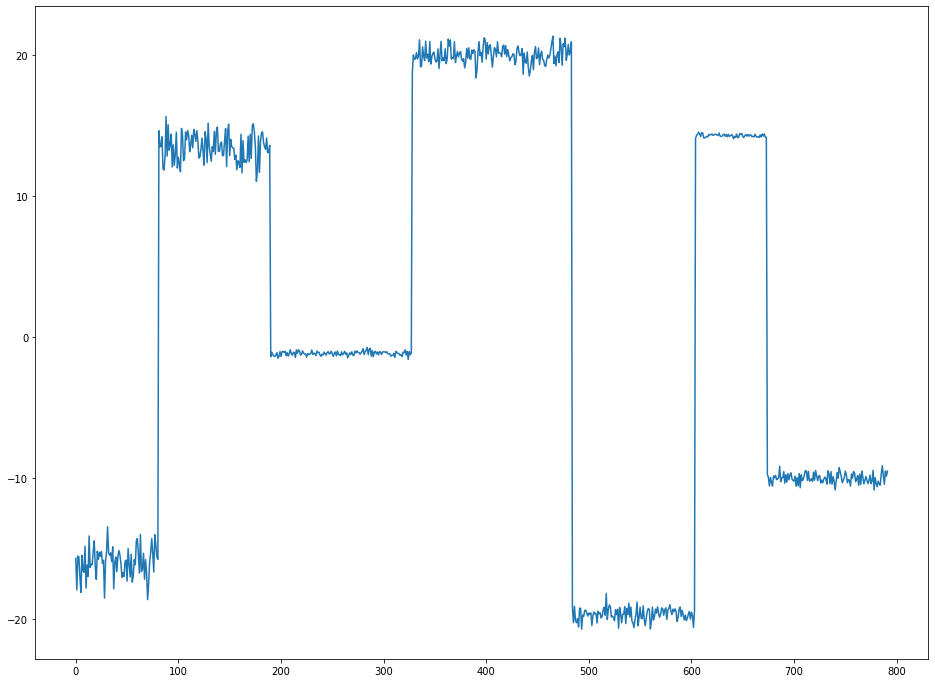

In [10]:
fig, ax = plt.subplots(figsize=[16, 12])
ax.plot(data)

## Offline Changepoint Detection

Lets compute the probability of changepoints at each time step. We need two things for that. First a prior of how probable is it to have two successive changepoints with the distance `t`. The second thing is a model of the likelihood of data in a sequence `[s, t]` of the data, given that in this sequence there is *no* changepoint.

For this example we assume a uniform prior over the length of sequences (`const_prior`) and a piecewise gaussian model (`gaussian_obs_log_likelihood`).

In [11]:
import cProfile

In [12]:
from __future__ import division
import numpy as np
from scipy.special import gammaln, multigammaln
from scipy.special import comb
from decorator import decorator

# This makes the code compatible with Python 3
# without causing performance hits on Python 2
try:
    xrange
except NameError:
    xrange = range


try:
    from sselogsumexp import logsumexp
except ImportError:
    from scipy.special import logsumexp
    print("Use scipy logsumexp().")
else:
    print("Use SSE accelerated logsumexp().")


def _dynamic_programming(f, *args, **kwargs):
    if f.data is None:
        f.data = args[0]

    if not np.array_equal(f.data, args[0]):
        f.cache = {}
        f.data = args[0]

    try:
        f.cache[args[1:3]]
    except KeyError:
        f.cache[args[1:3]] = f(*args, **kwargs)
    return f.cache[args[1:3]]

def dynamic_programming(f):
    f.cache = {}
    f.data = None
    return decorator(_dynamic_programming, f)


def offline_changepoint_detection(data, prior_func,
                                  observation_log_likelihood_function,
                                  truncate=-np.inf):
    """Compute the likelihood of changepoints on data.

    Keyword arguments:
    data                                -- the time series data
    prior_func                          -- a function given the likelihood of a changepoint given the distance to the last one
    observation_log_likelihood_function -- a function giving the log likelihood
                                           of a data part
    truncate                            -- the cutoff probability 10^truncate to stop computation for that changepoint log likelihood

    P                                   -- the likelihoods if pre-computed
    """

    n = len(data)
    Q = np.zeros((n,))
    g = np.zeros((n,))
    G = np.zeros((n,))
    P = np.ones((n, n)) * -np.inf

    # save everything in log representation
    for t in range(n):
        g[t] = np.log(prior_func(t))
        if t == 0:
            G[t] = g[t]
        else:
            G[t] = np.logaddexp(G[t-1], g[t])

    P[n-1, n-1] = observation_log_likelihood_function(data, n-1, n)
    Q[n-1] = P[n-1, n-1]

    for t in reversed(range(n-1)):
        P_next_cp = -np.inf  # == log(0)
        for s in range(t, n-1):
            P[t, s] = observation_log_likelihood_function(data, t, s+1)

            # compute recursion
            summand = P[t, s] + Q[s + 1] + g[s + 1 - t]
            P_next_cp = np.logaddexp(P_next_cp, summand)

            # truncate sum to become approx. linear in time (see
            # Fearnhead, 2006, eq. (3))
            if summand - P_next_cp < truncate:
                break

        P[t, n-1] = observation_log_likelihood_function(data, t, n)

        # (1 - G) is numerical stable until G becomes numerically 1
        if G[n-1-t] < -1e-15:  # exp(-1e-15) = .99999...
            antiG = np.log(1 - np.exp(G[n-1-t]))
        else:
            # (1 - G) is approx. -log(G) for G close to 1
            antiG = np.log(-G[n-1-t])

        Q[t] = np.logaddexp(P_next_cp, P[t, n-1] + antiG)

    Pcp = np.ones((n-1, n-1)) * -np.inf
    for t in range(n-1):
        Pcp[0, t] = P[0, t] + Q[t + 1] + g[t] - Q[0]
        if np.isnan(Pcp[0, t]):
            Pcp[0, t] = -np.inf
    for j in range(1, n-1):
        for t in range(j, n-1):
            tmp_cond = Pcp[j-1, j-1:t] + P[j:t+1, t] + Q[t + 1] + g[0:t-j+1] - Q[j:t+1]
            Pcp[j, t] = logsumexp(tmp_cond.astype(np.float32))
            if np.isnan(Pcp[j, t]):
                Pcp[j, t] = -np.inf

    return Q, P, Pcp

@dynamic_programming
def gaussian_obs_log_likelihood(data, t, s):
    s += 1
    n = s - t
    mean = data[t:s].sum(0) / n

    muT = (n * mean) / (1 + n)
    nuT = 1 + n
    alphaT = 1 + n / 2
    betaT = 1 + 0.5 * ((data[t:s] - mean) ** 2).sum(0) + ((n)/(1 + n)) * (mean**2 / 2)
    scale = (betaT*(nuT + 1))/(alphaT * nuT)

    # splitting the PDF of the student distribution up is /much/ faster.
    # (~ factor 20) using sum over for loop is even more worthwhile
    prob = np.sum(np.log(1 + (data[t:s] - muT)**2/(nuT * scale)))
    lgA = gammaln((nuT + 1) / 2) - np.log(np.sqrt(np.pi * nuT * scale)) - gammaln(nuT/2)

    return np.sum(n * lgA - (nuT + 1)/2 * prob)

def ifm_obs_log_likelihood(data, t, s):
    '''Independent Features model from xuan et al'''
    s += 1
    n = s - t
    x = data[t:s]
    if len(x.shape)==2:
        d = x.shape[1]
    else:
        d = 1
        x = np.atleast_2d(x).T

    N0 = d          # weakest prior we can use to retain proper prior
    V0 = np.var(x)
    Vn = V0 + (x**2).sum(0)

    # sum over dimension and return (section 3.1 from Xuan paper):
    return d*( -(n/2)*np.log(np.pi) + (N0/2)*np.log(V0) - \
        gammaln(N0/2) + gammaln((N0+n)/2) ) - \
        ( ((N0+n)/2)*np.log(Vn) ).sum(0)

def fullcov_obs_log_likelihood(data, t, s):
    '''Full Covariance model from xuan et al'''
    s += 1
    n = s - t
    x = data[t:s]
    if len(x.shape)==2:
        dim = x.shape[1]
    else:
        dim = 1
        x = np.atleast_2d(x).T

    N0 = dim          # weakest prior we can use to retain proper prior
    V0 = np.var(x)*np.eye(dim)
    
    # Improvement over np.outer
    # http://stackoverflow.com/questions/17437523/python-fast-way-to-sum-outer-products
    # Vn = V0 + np.array([np.outer(x[i], x[i].T) for i in xrange(x.shape[0])]).sum(0)
    Vn = V0 + np.einsum('ij,ik->jk', x, x)

    # section 3.2 from Xuan paper:
    return -(dim*n/2)*np.log(np.pi) + (N0/2)*np.linalg.slogdet(V0)[1] - \
        multigammaln(N0/2,dim) + multigammaln((N0+n)/2,dim) - \
        ((N0+n)/2)*np.linalg.slogdet(Vn)[1]

def const_prior(r, l):
    return 1/(l)

def geometric_prior(t, p):
    return p * ((1 - p) ** (t - 1))

def neg_binominal_prior(t, k, p):
    return comb(t - k, k - 1) * p ** k * (1 - p) ** (t - k)

Use scipy logsumexp().


In [13]:
#import bayesian_changepoint_detection.offline_changepoint_detection as offcd
from functools import partial

#Q, P, Pcp = offcd.offline_changepoint_detection(data, partial(offcd.const_prior, l=(len(data)+1)), offcd.gaussian_obs_log_likelihood, truncate=-40)
Q, P, Pcp = offline_changepoint_detection(data, partial(const_prior, l=(len(data)+1)), gaussian_obs_log_likelihood, truncate=-40)

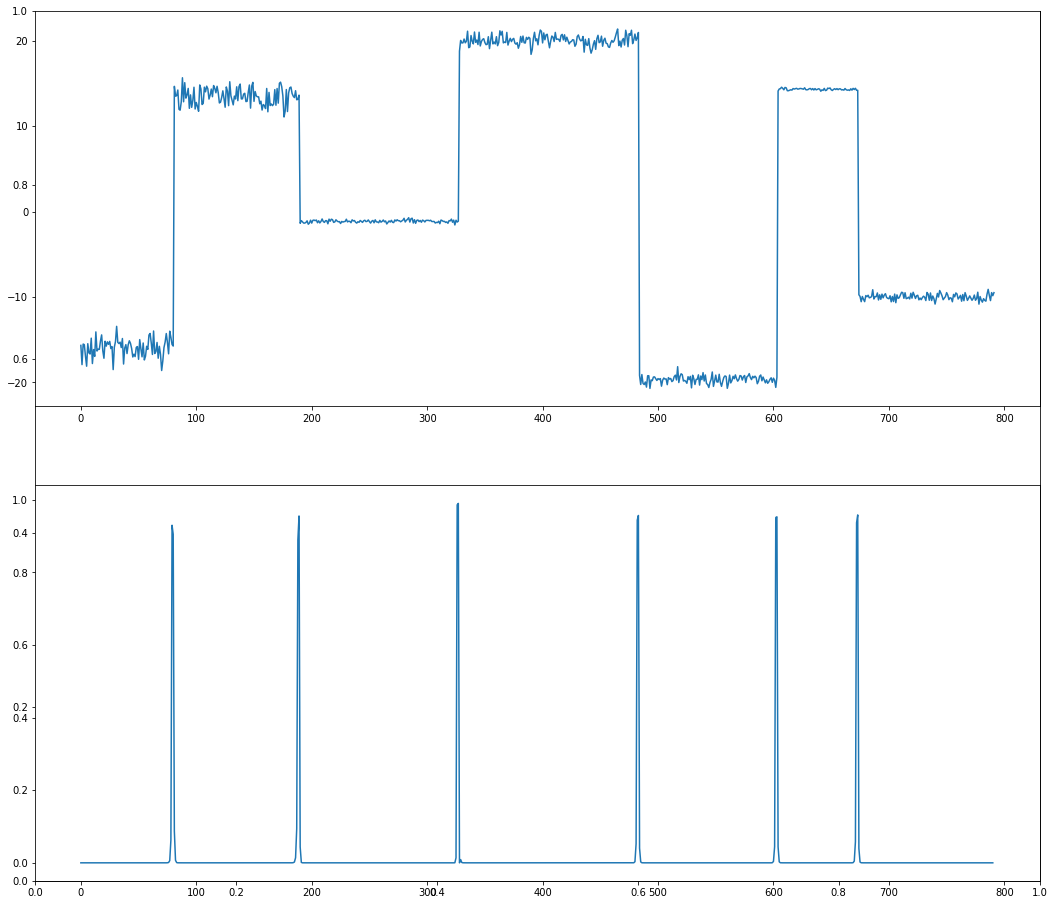

In [14]:
fig, ax = plt.subplots(figsize=[18, 16])
ax = fig.add_subplot(2, 1, 1)
ax.plot(data[:])
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp).sum(0))

# Regime switching model

This model is suited for estimating regime switches in time series. For pre-fixed number of states $K$, the algorithm estimates the probabilities of each time belonging in the $K$ states.

These models assume the regime to be a ‘hidden state’ whose probability and characteristics are estimated using maximum likelihood estimation. We will look into the details of these models below.

The steady-state equation of an asset price is defined as an autoregressive process. This is characterized by the intercept 𝜇, autocorrelation β, and volatility 𝜎, of the process specific to the market regime

Rt=μ+ β×Rt-1+ σϵ

The governing dynamics of the underlying regime, 𝑆𝑡, are assumed to follow a homogenous first-order Markov chain. Here, the probability of the next state depends only on the present state.

We can estimate the transition probabilities from one such state to the next through a Maximum Likelihood Estimator. This attempts to find the parameter values that maximize the likelihood function.

In [15]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [17]:
#Fit the model
#mod_kns = sm.tsa.MarkovRegression(data, k_regimes=3, trend='nc', switching_variance=True)
mod_kns = sm.tsa.MarkovAutoregression(data, k_regimes=2, order=4, switching_variance=False)
res_kns = mod_kns.fit()
res_kns.summary()

/Users/Momooo/anaconda2/envs/python36/lib/python3.6/site-packages/statsmodels/tsa/statespace/tools.py:502: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
/Users/Momooo/anaconda2/envs/python36/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Momooo/anaconda2/envs/python36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/Momooo/anaconda2/envs/python36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/Momooo/anaconda2/envs/python36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                        y   No. Observations:                  788
Model:             MarkovAutoregression   Log Likelihood                     nan
Date:                  Fri, 24 Jan 2020   AIC                                nan
Time:                          12:08:35   BIC                                nan
Sample:                               0   HQIC                               nan
                                  - 788                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7931        nan        nan        nan         nan         nan
ar.L1             nan        nan        nan        nan         nan         nan
ar.L2             nan        nan        nan        nan         nan         nan
ar.L3             nan        nan        nan        nan         nan         nan
ar.L4             nan        nan        nan        nan         nan         nan
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8418        nan        nan        nan         nan         nan
ar.L1          0.9571        nan        nan        nan         nan         nan
ar.L2          0.0319        nan        nan        nan         nan         nan
ar.L3          0.0284        nan        nan        nan         nan         nan
ar.L4         -0.0182        nan        nan        nan         nan         nan
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.1114        nan        nan        nan         nan         nan
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.0178        nan        nan        nan         nan         nan
p[1->0]        0.0103        nan        nan        nan         nan         nan
==============================================================================

Warnings:
[1] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

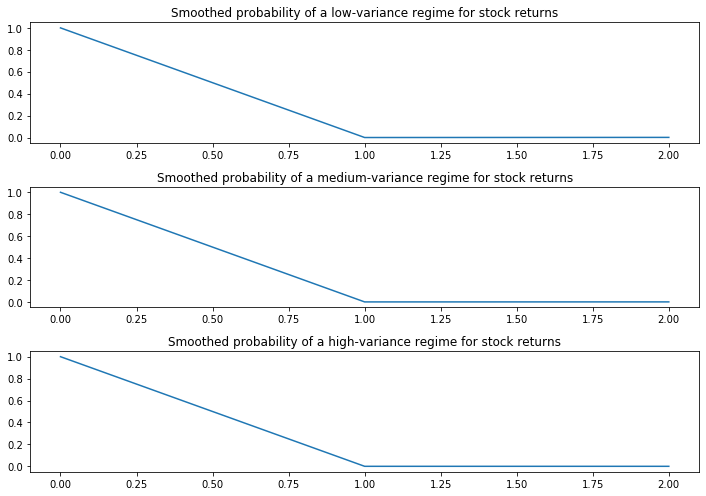

In [48]:
fig, axes = plt.subplots(3, figsize=(10,7))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of a low-variance regime for stock returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a medium-variance regime for stock returns')
ax = axes[2]
ax.plot(res_kns.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of a high-variance regime for stock returns')
fig.tight_layout()

# Intervention analysis using ARIMA

In [49]:
import pyflux as pf

In [54]:
data = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/MASS/drivers.csv")
data.head()

,Unnamed: 0,time,value
0,1,1969.000000,1687
1,2,1969.083333,1508
2,3,1969.166667,1507
3,4,1969.250000,1385
4,5,1969.333333,1632


[]

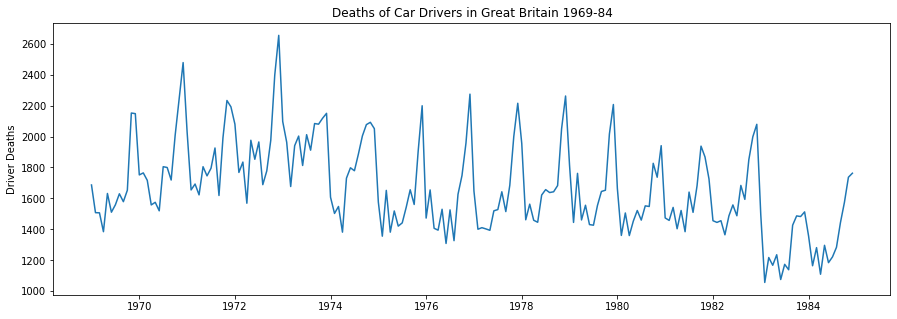

In [55]:
data.index = data['time'];
data.loc[(data['time']>=1983.05), 'seat_belt'] = 1;
data.loc[(data['time']<1983.05), 'seat_belt'] = 0;
data.loc[(data['time']>=1974.00), 'oil_crisis'] = 1;
data.loc[(data['time']<1974.00), 'oil_crisis'] = 0;
plt.figure(figsize=(15,5));
plt.plot(data.index, data['value']);
plt.ylabel('Driver Deaths');
plt.title('Deaths of Car Drivers in Great Britain 1969-84');
plt.plot()

In [57]:
model = pf.ARIMAX(data=data, formula='value~1+seat_belt+oil_crisis',
                  ar=1, ma=1, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: value                               Method: MLE                                       
Start Date: 1969.08333333333                            Log Likelihood: -1278.7644                        
End Date: 1984.91666666667                              AIC: 2569.5288                                    
Number of observations: 191                             BIC: 2589.0424                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.5004     0.0933     5.3637   0.0      (0.3175 | 0.6832)        
MA(1)                                

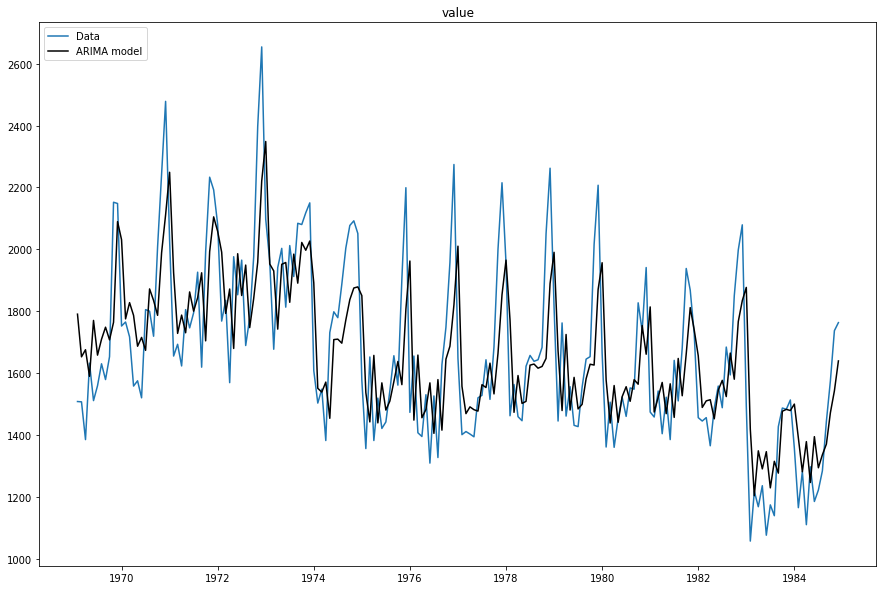

In [58]:
model.plot_fit(figsize=(15,10))

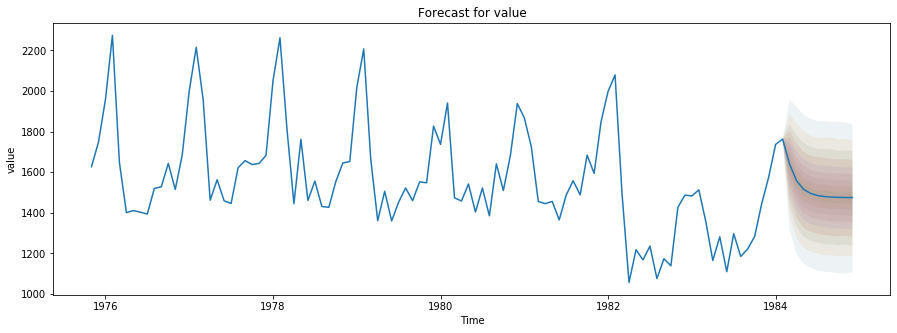

In [61]:
predicted = model.predict(h=10, oos_data=data.iloc[-12:],intervals=True)
model.plot_predict(h=10, oos_data=data.iloc[-12:], past_values=100, figsize=(15,5))

In [63]:
predicted.head()

,value,1% Prediction Interval,5% Prediction Interval,95% Prediction Interval,99% Prediction Interval
time,,,,,
1984.166667,1640.148331,1181.512449,1316.023799,1958.049888,2102.443125
1984.250000,1557.500462,1058.515414,1204.605317,1925.218519,2073.122935
1984.333333,1516.146210,993.293373,1149.170252,1888.586843,2023.032345
1984.416667,1495.453914,958.966502,1125.401573,1867.055056,2023.066263
1984.500000,1485.100175,952.674128,1113.268675,1856.285209,2012.617682


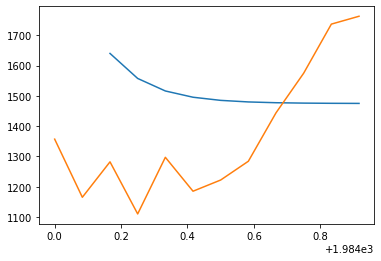

In [65]:
plt.plot(predicted['value'])
plt.plot(data.iloc[-12:]['value'])